# BERT Training

This notebook is dedicated to training the BERT model that I have built. Since BERT is a complex model and requires lots computing power, I need to leverage Google Colab for GPU power.

In [85]:
!pip install transformers

In [86]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import nltk
from nltk.corpus import stopwords
from google.colab import drive

drive.mount('/content/drive/')

%matplotlib inline

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [87]:
# Preprocessing Class
"""

@author: Jinal Shah

This file will be dedicated to a Preprocessing
class to preprocess the data

"""
class Preprocessing():
    # Constructor
    def __init__(self,strip_chars="#-'.;:)([]!?|/*@",replacements={"\n":" ", "\t": " ", "&gt":"", "&lt":"", "&amp":" and "}):
        """
        constructor

        Class constructor

        inputs:
        - strip_chars: a string of characters to strip from each word
        - replacements: a dictionary where key is the set of characters and the value is the value to replace
        the characters with.

        outputs:
        - None
        """
        self.strip_chars = strip_chars
        self.replacements = replacements

        # Creating a list for the stop words
        nltk.download('stopwords')
        self.stop_words = stopwords.words('english')

    # Creating a function to drop the columns
    def drop_columns(self,data,columns=['location','id','keyword']):
        """
        drop_columns

        A function to drop the listed columns in the data

        inputs:
        - data: data is a Pandas Dataframe containing the data
        - columns: a list of columns to drop

        outputs:
        - The new dataframe with the dropped columns
        """
        return data.drop(columns,axis=1)
        # try:
        #     return data.drop(columns,axis=1)
        # except Exception:
        #     return None

    # Creating a function to perform the preprocessing
    def preprocess_data(self,data):
        """
        preprocess_data

        A function to preprocess the data

        inputs:
        - data: a Pandas Dataframe containing the raw data

        outputs:
        - A numpy array containing the preprocessed sentences at each index
        """
        # Dropping the columns
        text_data = self.drop_columns(data)

        # Convert the text data to a numpy array
        text_data_arr = text_data.to_numpy()
        processed_sentences = []

        # Getting the preprocessed text
        for sentence in text_data_arr:
            # Making the replacements
            preprocessed_sentence = sentence[0]
            for replacements in self.replacements.keys():
                preprocessed_sentence = preprocessed_sentence.replace(replacements,self.replacements[replacements])

            # Splitting the sentence by space
            preprocessed_sentence_arr = preprocessed_sentence.split(' ')
            final_preprocessed_sentence = [] # an array for the preprocessed sentence

            for word in preprocessed_sentence_arr:
                processed_word = word.strip(self.strip_chars)
                processed_word = processed_word.lower()
                processed_word = processed_word.encode('ascii','ignore')
                processed_word = processed_word.decode()

                # Conditions to add it to the final preprocessed sentence
                if (processed_word != "") and (processed_word not in self.stop_words) and ("http" not in processed_word) and ("@" not in processed_word):
                    final_preprocessed_sentence.append(processed_word)

            processed_sentences.append(final_preprocessed_sentence)

        # returning the preprocessed sentences
        return processed_sentences




In [88]:
# BERT Model Class
class BERT(nn.Module):
    # Constructor
    def __init__(self):
        """
        constructor

        This will contruct the model.

        inputs:
        - None
        outputs:
        - None

        """
        super().__init__()

        # Getting the BERT model and freezing the parameters
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freezing the parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        # Create the classifier
        self.output = nn.Linear(768,2,bias=True)

    # Forward Method to get the predictions
    def forward(self,x):
        """
        forward

        This method will take the input and provide us the output

        inputs:
        - x: the inputs to the model

        outputs:
        - output: the prediction
        """
        output = self.bert(x,output_attentions=False,output_hidden_states=False)

        # Passing the output of Bert through the classifer
        output = F.softmax(self.output(output[0][:,0,:]),dim=1)

        # Returning the output
        return output


In [89]:
# Adding this part so that Google Colab can find my data file
%cd /content/drive/My Drive

/content/drive/My Drive


In [90]:
# Setting the device
device = torch.device('cuda')

In [91]:
# Getting the data and preprocessing it
# Importing the data
raw_train = pd.read_csv('train.csv')

# Splitting the data into training, validation, and testing
training, testing = train_test_split(raw_train,test_size=0.2,random_state=42,shuffle=True,stratify=raw_train['target'])
validation, testing = train_test_split(testing,test_size=0.2,random_state=42,shuffle=True,stratify=testing['target'])
training.reset_index(drop=True,inplace=True)
validation.reset_index(drop=True,inplace=True)
testing.reset_index(drop=True,inplace=True)

# Splitting data into X & Y
train_x = training.drop(['target'],axis=1)
train_y = training['target'].values
valid_x = validation.drop(['target'],axis=1)
valid_y = validation['target'].values

# Getting the preprocessed text
preprocessor = Preprocessing()
preprocessed_train_x = preprocessor.preprocess_data(train_x)
preprocessed_valid_x = preprocessor.preprocess_data(valid_x)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
# Tokenizing the preprocessed words using BERT's tokenizer because BERT leverages a specific vocabulary
# and specific characters (CLS f.e)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

# Getting the tokenized data
training_X = []
valid_X = []
for sentence_index in range(0,len(preprocessed_train_x)):
    training_X.append(tokenizer.encode(preprocessed_train_x[sentence_index],padding='max_length',truncation=True,max_length=57))

for sentence_index in range(0,len(preprocessed_valid_x)):
    valid_X.append(tokenizer.encode(preprocessed_valid_x[sentence_index],padding='max_length',truncation=True,max_length=57))

train_X = torch.from_numpy(np.array(training_X))
valid_X = torch.from_numpy(np.array(valid_X))
train_y = torch.from_numpy(train_y)
valid_y = torch.from_numpy(valid_y)

training_dataset = TensorDataset(train_X,train_y)
validation_dataset = TensorDataset(valid_X,valid_y)

# Storing the training and validation data in DataLoaders
training_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)
validation_loader = DataLoader(validation_dataset,batch_size=32,shuffle=True)

In [93]:
# Setting up looking at performance
training_metrics = []
validation_metrics = []

# Creating a function that returns the metrics
def get_metrics(truth,predictions):
    f1 = f1_score(truth,predictions)
    precision = precision_score(truth,predictions)
    recall = recall_score(truth,predictions)
    accuracy = accuracy_score(truth,predictions)
    return f1, precision, recall, accuracy

In [94]:
# Creating the training loop for PyTorch
def training_loop(model,loss_fn,optimizer,training_data):
    size = len(training_data.dataset)
    model.train() # Setting the model to training mode

    # Iterating through the batches
    for batch , (X,y) in enumerate(training_data):
      # Putting data on to GPU
      X = X.to(device)
      y = y.to(device)

      # Compute the predictions
      pred = model(X)

      # Calculate the loss
      loss = loss_fn(pred,y)

      # Calculate the derivatives (backpropagation)
      loss.backward()

      # Take a step with the optimizer
      optimizer.step()

      # Reset the gradients
      optimizer.zero_grad()

      # Printing out the progress for every 20 batches
      if batch % 20 == 0:
          loss, current = loss.item(), (batch+1) * len(X)
          print(f'loss :{loss / len(X)} {round(current/size,2)*100}% Complete')

In [95]:
# Function for prediction
def evaluation(model,loss_fn,data):
    size = len(data.dataset)
    model.eval() # Setting the model to evaluation mode
    total_loss = 0

    # Iterating through the batches
    for batch , (X,y) in enumerate(data):
      # Putting data on to GPU
      X = X.to(device)
      y = y.to(device)

      # Compute the predictions
      pred = model(X)

      # Calculate the loss
      total_loss += loss_fn(pred,y)

    # Returning the average loss
    return total_loss.item() / size

In [96]:
model = BERT()
model.to(device) # Putting the model on GPU
epochs = 25
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
loss_function = torch.nn.CrossEntropyLoss()
history = []

In [97]:
# Training the model
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    training_loop(model,loss_function,optimizer,training_loader)
    train_loss = evaluation(model,loss_function,training_loader)
    history.append(train_loss)
    print()

Epoch 1
-------------------------------
loss :0.023491619154810905 1.0% Complete
loss :0.023168861865997314 11.0% Complete
loss :0.022549016401171684 22.0% Complete
loss :0.021955478936433792 32.0% Complete
loss :0.02244018390774727 43.0% Complete
loss :0.02156650274991989 53.0% Complete
loss :0.022111915051937103 64.0% Complete
loss :0.02219569869339466 74.0% Complete
loss :0.022040169686079025 85.0% Complete
loss :0.021342024207115173 95.0% Complete

Epoch 2
-------------------------------
loss :0.02181161195039749 1.0% Complete
loss :0.02164268121123314 11.0% Complete
loss :0.0216873437166214 22.0% Complete
loss :0.021863320842385292 32.0% Complete
loss :0.021421553567051888 43.0% Complete
loss :0.021599669009447098 53.0% Complete
loss :0.02145933359861374 64.0% Complete
loss :0.02093507908284664 74.0% Complete
loss :0.02139686606824398 85.0% Complete
loss :0.02095075696706772 95.0% Complete

Epoch 3
-------------------------------
loss :0.021587800234556198 1.0% Complete
loss :0.02

In [98]:
# Making the training predictions
train_pred = []
model.eval()

with torch.no_grad():
  for batch,(X,y) in enumerate(training_loader):
    # Putting data on to GPU
    X = X.to(device)
    y = y.to(device)

    # Compute the predictions
    pred = model(X)
    pred = np.argmax(pred.to('cpu').numpy(),axis=1)
    # Adding the predictions to the list
    train_pred.extend(list(pred))

In [99]:
# Making the validation predictions
valid_pred = []
model.eval()

with torch.no_grad():
  for batch,(X,y) in enumerate(validation_loader):
    # Putting data on to GPU
    X = X.to(device)
    y = y.to(device)

    # Compute the predictions
    pred = model(X)
    pred = np.argmax(pred.to('cpu').numpy(),axis=1)

    # Adding the predictions to the list
    valid_pred.extend(list(pred))

In [100]:
# Printing the model results
train_metrics = get_metrics(train_y,train_pred)
valid_metrics = get_metrics(valid_y,valid_pred)
train_metrics_df = {'Name':'BERT','F1':train_metrics[0],'Precision':train_metrics[1],'Recall':train_metrics[2],'Accuracy':train_metrics[3]}
valid_metrics_df = {'Name':'BERT','F1':valid_metrics[0],'Precision':valid_metrics[1],'Recall':valid_metrics[2],'Accuracy':valid_metrics[3]}

training_metrics.append(train_metrics_df)
validation_metrics.append(valid_metrics_df)
print('Finished BERT Model')
print()

Finished BERT Model



In [101]:
training_metrics_df = pd.DataFrame(training_metrics)
validation_metrics_df = pd.DataFrame(validation_metrics)
print('Training Metrics:')
print(training_metrics_df)
print()
print('Validation Metrics:')
print(validation_metrics_df)

Training Metrics:
   Name       F1  Precision    Recall  Accuracy
0  BERT  0.02359   0.333333  0.012228  0.565025

Validation Metrics:
   Name        F1  Precision   Recall  Accuracy
0  BERT  0.037037   0.588235  0.01912  0.573071


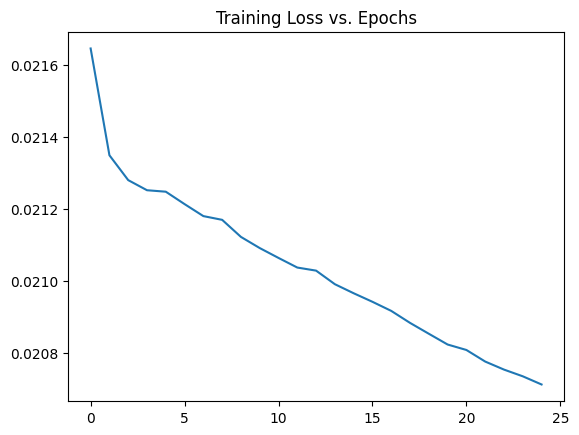

In [102]:
# Plotting the learning curve
plt.title('Training Loss vs. Epochs')
plt.plot(history)
plt.show()

In [103]:
# Saving the metrics to a file
training_metrics_df.to_csv('training-BERT.csv',index=False)
validation_metrics_df.to_csv('validation-BERT.csv',index=False)